In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import transforms_data
from model import Net

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


In [3]:
#Function to load the mnist data from utils library
train_data,test_data= transforms_data()


100%|██████████| 9912422/9912422 [00:00<00:00, 238085676.42it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 3672336.56it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33415914.83it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18459814.70it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
#Configuring the batch size, shuffle, workers parameters and loading the data
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

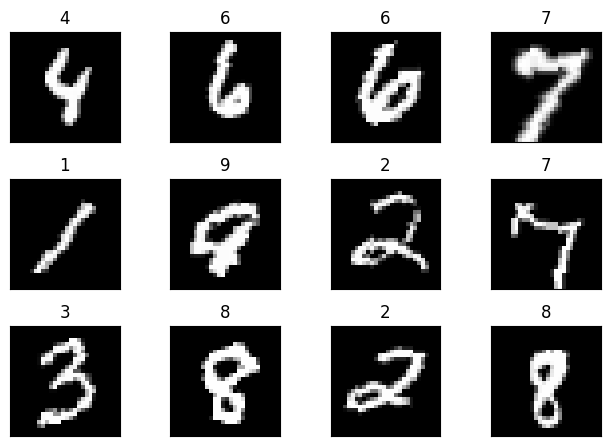

In [7]:
#plotting to see what is inside the mnist data
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [9]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [10]:
#Model is loaded from the model.py
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# Loss function
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2463 Batch_id=117 Accuracy=56.82: 100%|██████████| 118/118 [00:40<00:00,  2.95it/s]


Test set: Average loss: 0.1931, Accuracy: 9425/10000 (94.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3358 Batch_id=117 Accuracy=94.35: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0822, Accuracy: 9733/10000 (97.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1807 Batch_id=117 Accuracy=96.42: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s]


Test set: Average loss: 0.0561, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0177 Batch_id=117 Accuracy=97.13: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


Test set: Average loss: 0.0495, Accuracy: 9827/10000 (98.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2272 Batch_id=117 Accuracy=97.45: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s]


Test set: Average loss: 0.0400, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0422 Batch_id=117 Accuracy=97.80: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s]


Test set: Average loss: 0.0389, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0547 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0339, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0251 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:24<00:00,  4.77it/s]


Test set: Average loss: 0.0316, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0694 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


Test set: Average loss: 0.0347, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0438 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0369 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:24<00:00,  4.72it/s]


Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0874 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0278, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0217 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0268, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0456 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Test set: Average loss: 0.0257, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0096 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:24<00:00,  4.79it/s]


Test set: Average loss: 0.0265, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0588 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0218, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0147 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:24<00:00,  4.82it/s]


Test set: Average loss: 0.0212, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0473 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0208, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0111 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0631 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Test set: Average loss: 0.0210, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [11]:
# Model summary to see what parameters does the model contain
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


Text(0.5, 1.0, 'Test Accuracy')

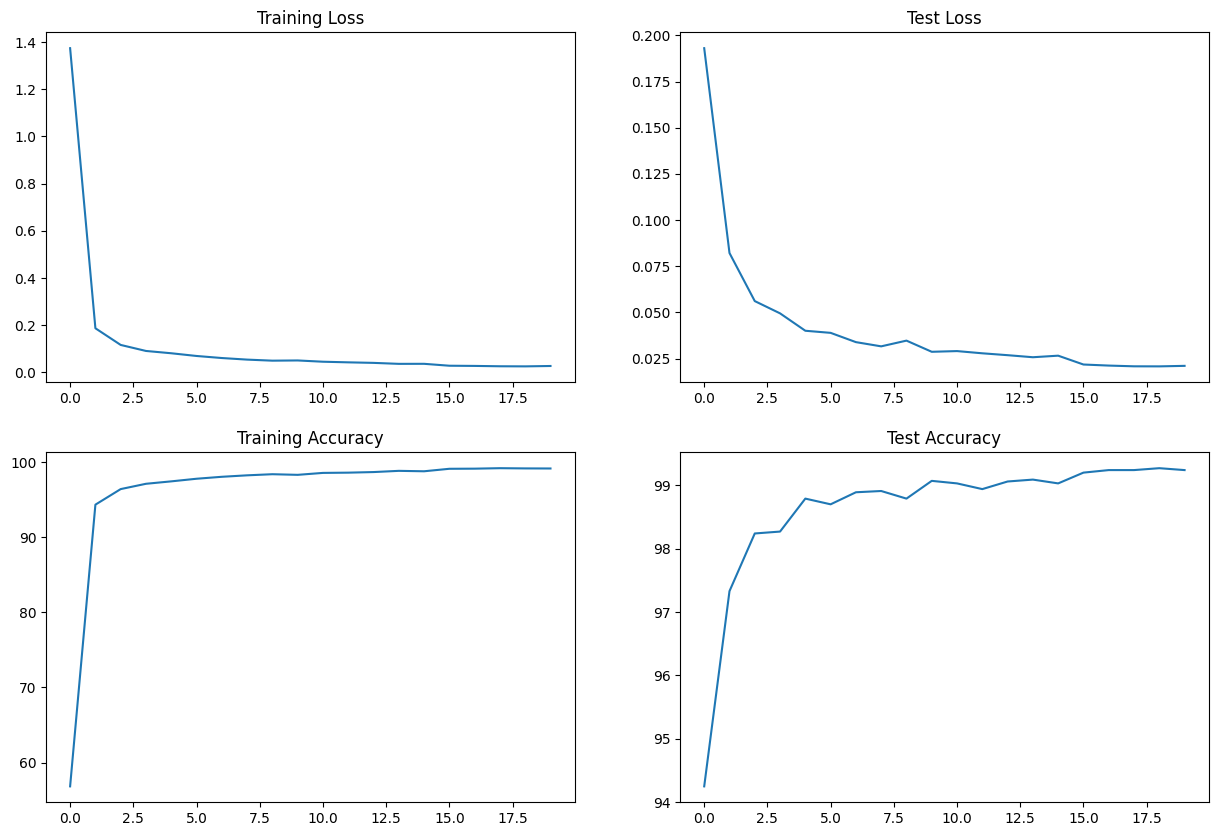

In [12]:
#Visualizing the accuracy and losses
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")